# Multi-Branch Shuffle Network with Coordinate Attention for Hyperspectral Image Classification

Author: Ao Meng, Taosheng Xu*

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization, ReLU
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras import backend as Kb
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Activation
from tensorflow.python.keras.layers.merge import add, concatenate
from tensorflow.keras.layers import AveragePooling2D
# from tensorflow.keras.utils.vis_utils import plot_model
import tensorflow.keras.backend as backend
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
 
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from operator import truediv
 
from plotly.offline import init_notebook_mode
 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import tensorflow as tf
import spectral

In [2]:
def applyFA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    fa = FactorAnalysis(n_components=numComponents, random_state=0)
    newX = fa.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, fa
    

In [3]:
# def applyPCA(X, numComponents=75):
#     newX = np.reshape(X, (-1, X.shape[2]))
#     pca = PCA(n_components=numComponents, whiten=True)
#     newX = pca.fit_transform(newX)
#     newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
#     return newX, pca

In [4]:
## GLOBAL VARIABLES
dataset = 'SA'
test_ratio = 0.5
windowSize = 32

In [5]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [6]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [7]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [8]:
def createImageCubes(X, y, windowSize=8, removeZeroLabels = True):
    margin = int((windowSize) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin , c - margin:c + margin ]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [9]:
X, y = loadData(dataset)

X.shape, y.shape

((512, 217, 204), (512, 217))

In [10]:
K = X.shape[2]

In [11]:
K = 3 if dataset == 'IP' else 3
X,fa = applyFA(X,numComponents=K)

X.shape

(512, 217, 3)

In [12]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((54129, 32, 32, 3), (54129,))

In [13]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((27064, 32, 32, 3), (27065, 32, 32, 3), (27064,), (27065,))

In [14]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(27064, 32, 32, 3, 1)

In [15]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(27064, 16)

In [16]:
S1 = windowSize
L1 = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [17]:
def CoordAtt(x, reduction=32, bn_trainable=False):
    def coord_act(x):
        tmpx = (ReLU(max_value=6)(x + 3)) / 6
        x = x * tmpx
        return x

    x_shape = x.shape.as_list()
    [b, h, w, c] = x_shape
    x_h = AveragePooling2D(pool_size=(1, w), strides=(1, 1), data_format='channels_last')(x)
    x_w = AveragePooling2D(pool_size=(h, 1), strides=(1, 1), data_format='channels_last')(x)
    x_w = backend.permute_dimensions(x_w, [0, 2, 1, 3])
    y = concatenate(inputs=[x_h, x_w], axis=1)
    mip = max(8, c // reduction)
    y = Conv2D(filters=mip, kernel_size=(1, 1), strides=(1, 1), padding='valid')(y)
    y = BatchNormalization(trainable=bn_trainable)(y)
    y = coord_act(y)
    x_h, x_w = Lambda(tf.split, arguments={'axis': 1, 'num_or_size_splits': [h, w]})(y)
    x_w = backend.permute_dimensions(x_w, [0, 2, 1, 3])
    a_h = Conv2D(filters=c, kernel_size=(1, 1), strides=(1, 1), padding='valid', activation="sigmoid")(x_h)
    a_w = Conv2D(filters=c, kernel_size=(1, 1), strides=(1, 1), padding='valid', activation="sigmoid")(x_w)
    out = x * a_h * a_w
    return out


def ConvBNReLU(inputs, filters, kernel_size, strides):
    x = tf.keras.layers.Conv2D(filters=filters,
                                  kernel_size=kernel_size,
                                  strides=strides,
                                  padding='same',
                                  kernel_regularizer=tf.keras.regularizers.l2(4e-5),
                                  use_bias=False,)(inputs)
    x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
    x = tf.keras.layers.ReLU()(x)
    return x




def DWConvBN(inputs, strides = 1):
    x = layers.DepthwiseConv2D(kernel_size=(3, 3),
                                              strides=strides,
                                              padding='same',
                                              use_bias=False,
                                              kernel_regularizer=tf.keras.regularizers.l2(4e-5),
                              )(inputs)
    x = layers.BatchNormalization(momentum=0.9)(x)
    return x



def aspp_1(tensor, filter):
    '''atrous spatial pyramid pooling'''
    dims = backend.int_shape(tensor)
    y_pool = tf.keras.layers.AveragePooling2D(pool_size=(
        dims[1], dims[2]))(tensor)
    y_pool = tf.keras.layers.DepthwiseConv2D(kernel_size=(1, 1),
                                             padding='same',
                                             use_bias=False,
                                             kernel_regularizer=tf.keras.regularizers.l2(4e-5),)(y_pool)

    y_pool = tf.keras.layers.UpSampling2D(size=[dims[1], dims[2]])(y_pool)

    ## 1x1 DW conv
    y_1 = tf.keras.layers.DepthwiseConv2D( kernel_size=(3, 3),
                                           dilation_rate=(1, 1),
                                           padding='same',
                                           use_bias=False,
                                           kernel_regularizer=tf.keras.regularizers.l2(4e-5))(tensor)


    ## 3x3 DW conv
    y_6 = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3),
                                          dilation_rate=(6, 6),
                                          padding='same',
                                          use_bias=False,
                                          kernel_regularizer=tf.keras.regularizers.l2(4e-5))(tensor)


    ## 3x3 DW conv
    y_12 = tf.keras.layers.DepthwiseConv2D( kernel_size=(3, 3),
                                            dilation_rate=(12, 12),
                                            padding='same',
                                            use_bias=False,
                                            kernel_regularizer=tf.keras.regularizers.l2(4e-5))(tensor)


    ## 3x3 DW conv
    y_18 = tf.keras.layers.DepthwiseConv2D( kernel_size=(3, 3),
                                            dilation_rate=(18, 18),
                                            padding='same',
                                            use_bias=False,
                                            kernel_regularizer=tf.keras.regularizers.l2(4e-5))(tensor)


    ## concat
    y = tf.keras.layers.concatenate([y_pool, y_1, y_6, y_12, y_18],)
    y = tf.keras.layers.Conv2D(filters=filter, kernel_size=1,
                                dilation_rate=1, padding='same',
                                kernel_initializer='he_normal',

                                use_bias=False)(y)
    y = CoordAtt(y)

    return y

def aspp_2(tensor, filter):
    '''atrous spatial pyramid pooling'''
    dims = backend.int_shape(tensor)
    y_pool = tf.keras.layers.AveragePooling2D(pool_size=(
        dims[1], dims[2]))(tensor)
    y_pool = tf.keras.layers.DepthwiseConv2D(kernel_size=(2, 2),
                                             strides=(2, 2),
                                             padding='same',
                                             use_bias=False,
                                             kernel_regularizer=tf.keras.regularizers.l2(4e-5), )(y_pool)
    y_pool = tf.keras.layers.UpSampling2D(size=[dims[1]/2, dims[2]/2])(y_pool)

    ## 1x1 DW conv
    y_1 = tf.keras.layers.DepthwiseConv2D(kernel_size=(2, 2),
                                          strides=(2, 2),
                                          dilation_rate=(1, 1),
                                          padding='same',
                                          use_bias=False,
                                          kernel_regularizer=tf.keras.regularizers.l2(4e-5))(tensor)

    ## 3x3 DW conv
    y_6 = tf.keras.layers.DepthwiseConv2D(kernel_size=(2, 2),
                                          strides=(2, 2),
                                          padding='same',
                                          use_bias=False)(tensor)
    y_6 = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3),
                                         strides=(1, 1),
                                         dilation_rate=(6, 6),
                                         padding='same',
                                         use_bias=False,
                                         kernel_regularizer=tf.keras.regularizers.l2(4e-5))(y_6)

    ## 3x3 DW conv
    y_12 = tf.keras.layers.DepthwiseConv2D(kernel_size=(2, 2),
                                           strides=(2, 2),
                                           padding='same',
                                           use_bias=False)(tensor)
    y_12 = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3),
                                           dilation_rate=(12, 12),
                                           strides=(1, 1),
                                           padding='same',
                                           use_bias=False,
                                           kernel_regularizer=tf.keras.regularizers.l2(4e-5))(y_12)

    ## 3x3 DW conv
    y_18 = tf.keras.layers.DepthwiseConv2D(kernel_size=(2, 2),
                                           strides=(2, 2),
                                           padding='same',
                                           use_bias=False)(tensor)
    y_18 = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3),
                                           strides=(1, 1),
                                           dilation_rate=(18, 18),
                                           padding='same',
                                           use_bias=False,
                                           kernel_regularizer=tf.keras.regularizers.l2(4e-5))(y_18)

    ## concat
    y = tf.keras.layers.concatenate([y_pool, y_1, y_6, y_12, y_18], )
    y = tf.keras.layers.Conv2D(filters=filter, kernel_size=1,
                               dilation_rate=1, padding='same',
                               kernel_initializer='he_normal',

                               use_bias=False)(y)
    y = CoordAtt(y)

    return y

def ChannelShuffle(inputs,shape):
    b, h, w, c = shape
    groups = 2

    x_reshaped = tf.reshape(inputs, [-1, h, w, groups, c // groups])

    x_transposed = tf.transpose(x_reshaped, [0, 1, 2, 4, 3])

    x = tf.reshape(x_transposed, [-1, h, w, c])

    return x

def ChannelSplit(inputs):
    num_splits: int = 2
    b1, b2 = tf.split(inputs,
                      num_or_size_splits=num_splits,
                      axis=-1)
    return b1, b2



def shuffle_block_s1(inputs, output_c: int, stride: int):
    if stride != 1:
        raise ValueError("illegal stride value.")

    assert output_c % 2 == 0
    branch_c = output_c // 2

    x1, x2 = ChannelSplit(inputs)

    # main branch
    x2 = ConvBNReLU(x2, filters=branch_c, kernel_size=1, strides=1)
    x2 = aspp_1(x2, branch_c)
    x2 = ConvBNReLU(x2, filters=branch_c, kernel_size=1, strides=1)

    out_put = layers.concatenate([x1, x2],axis=-1)

    x = ChannelShuffle(out_put,out_put.shape)

    return x


def shuffle_block_s2(inputs, output_c: int, stride: int):
    if stride != 2:
        raise ValueError("illegal stride value.")

    assert output_c % 2 == 0
    branch_c = output_c // 2

    # shortcut branch
    x1 = DWConvBN(inputs, strides=stride)
    x1 = ConvBNReLU(x1,filters=branch_c,kernel_size=1, strides=1)

    # main branch
    x2 = ConvBNReLU(inputs,filters=branch_c,kernel_size=1, strides=1)
    x2 = aspp_2(x2, branch_c)
    x2 = ConvBNReLU(x2,filters=branch_c,kernel_size=1, strides=1)

    out_put = layers.concatenate([x1, x2],axis=-1)
    x = ChannelShuffle(out_put,out_put.shape)

    return x


def _make_layer(repeat_num, inputs, output_c, stride_1, stride_2):
    block = tf.keras.Sequential()
    block.add(shuffle_block_s2(inputs, output_c, stride_2))
    for i in range(1, repeat_num):
        block.add(shuffle_block_s1(inputs, output_c, stride_1))
    return block

In [18]:
def MSNCA(img_input, ):
    input_ = Input(img_input, name='the_input')
    # Block 1
    repeat =[4,8,4]
    x = Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      kernel_initializer = RandomNormal(stddev=0.02),
                      name='block1_conv1')(input_)

    x = ConvBNReLU(x,
                   filters=128,
                   kernel_size=3,
                   strides=2)


    x = shuffle_block_s2(x, output_c=256, stride=2)
    for i in (1, repeat[0]):
        x = shuffle_block_s1(x, output_c=256, stride=1)


    x = shuffle_block_s2(x, output_c=512, stride=2)
    for i in (1, repeat[1]):
        x = shuffle_block_s1(x, output_c=512, stride=1)


    x = shuffle_block_s2(x, output_c=1024, stride=2)
    for i in (1, repeat[2]):
        x = shuffle_block_s1(x, output_c=1024, stride=1)

#     x = ConvBNReLU(x, filters=2048 , kernel_size=1, strides=1)
    x = layers.GlobalAveragePooling2D(name="globalpool")(x)
    x = layers.Dense(units=output_units, name="fc")(x)
    x = layers.Softmax()(x)
    model = Model(inputs=input_, outputs=x)
    model.summary()
    return model

In [19]:
model = MSNCA(img_input=(32, 32, 3))

2023-06-05 22:21:52.229614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 22:21:52.276358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 22:21:52.276643: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 22:21:52.281437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 22:21:52.281657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 the_input (InputLayer)         [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['the_input[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 128)  73728       ['block1_conv1[0][0]']           
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 128)  512        ['conv2d[0][0]']                 
 alization)                                                                                   

In [20]:
# adam = Adam(learning_rate=0.001, decay=1e-06)
sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [21]:
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

In [22]:
history = model.fit(x=Xtrain, y=ytrain, batch_size =128, epochs=100, callbacks=callbacks_list)

Epoch 1/100


2023-06-05 22:22:07.308181: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8500
2023-06-05 22:22:08.078370: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-05 22:22:08.510850: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


212/212 [==============================] - ETA: 0s - loss: 1.0000 - accuracy: 0.8503
Epoch 00001: saving model to best-model.hdf5
212/212 [==============================] - 63s 241ms/step - loss: 1.0000 - accuracy: 0.8503
Epoch 2/100
212/212 [==============================] - ETA: 0s - loss: 0.3550 - accuracy: 0.9916
Epoch 00002: saving model to best-model.hdf5
212/212 [==============================] - 50s 238ms/step - loss: 0.3550 - accuracy: 0.9916
Epoch 3/100
212/212 [==============================] - ETA: 0s - loss: 0.2935 - accuracy: 0.9976
Epoch 00003: saving model to best-model.hdf5
212/212 [==============================] - 51s 240ms/step - loss: 0.2935 - accuracy: 0.9976
Epoch 4/100
212/212 [==============================] - ETA: 0s - loss: 0.2797 - accuracy: 0.9982
Epoch 00004: saving model to best-model.hdf5
212/212 [==============================] - 51s 239ms/step - loss: 0.2797 - accuracy: 0.9982
Epoch 5/100
212/212 [==============================] - ETA: 0s - loss: 0.271

Epoch 36/100
212/212 [==============================] - ETA: 0s - loss: 0.2526 - accuracy: 1.0000
Epoch 00036: saving model to best-model.hdf5
212/212 [==============================] - 51s 240ms/step - loss: 0.2526 - accuracy: 1.0000
Epoch 37/100
212/212 [==============================] - ETA: 0s - loss: 0.2526 - accuracy: 1.0000
Epoch 00037: saving model to best-model.hdf5
212/212 [==============================] - 51s 239ms/step - loss: 0.2526 - accuracy: 1.0000
Epoch 38/100
212/212 [==============================] - ETA: 0s - loss: 0.2525 - accuracy: 0.9999
Epoch 00038: saving model to best-model.hdf5
212/212 [==============================] - 50s 237ms/step - loss: 0.2525 - accuracy: 0.9999
Epoch 39/100
212/212 [==============================] - ETA: 0s - loss: 0.2522 - accuracy: 1.0000
Epoch 00039: saving model to best-model.hdf5
212/212 [==============================] - 51s 238ms/step - loss: 0.2522 - accuracy: 1.0000
Epoch 40/100
212/212 [==============================] - ETA:

Epoch 71/100
212/212 [==============================] - ETA: 0s - loss: 0.2489 - accuracy: 1.0000
Epoch 00071: saving model to best-model.hdf5
212/212 [==============================] - 50s 237ms/step - loss: 0.2489 - accuracy: 1.0000
Epoch 72/100
212/212 [==============================] - ETA: 0s - loss: 0.2491 - accuracy: 0.9999
Epoch 00072: saving model to best-model.hdf5
212/212 [==============================] - 50s 237ms/step - loss: 0.2491 - accuracy: 0.9999
Epoch 73/100
212/212 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 1.0000
Epoch 00073: saving model to best-model.hdf5
212/212 [==============================] - 51s 239ms/step - loss: 0.2488 - accuracy: 1.0000
Epoch 74/100
212/212 [==============================] - ETA: 0s - loss: 0.2487 - accuracy: 1.0000
Epoch 00074: saving model to best-model.hdf5
212/212 [==============================] - 51s 239ms/step - loss: 0.2487 - accuracy: 1.0000
Epoch 75/100
212/212 [==============================] - ETA:

# Validation

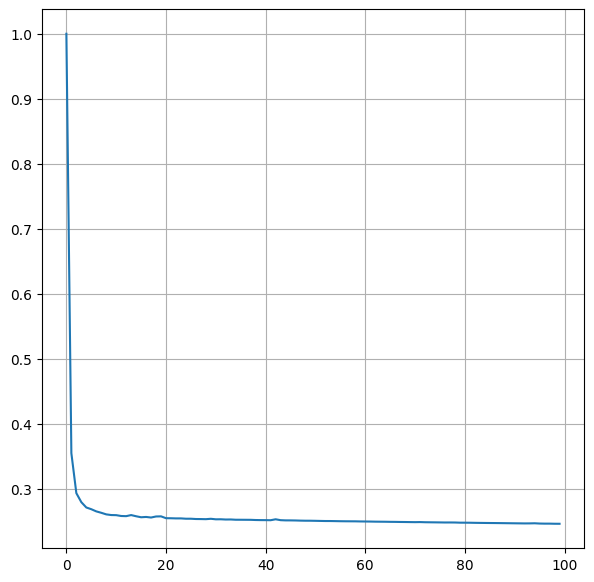

In [23]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.ylabel('Loss') 
#plt.xlabel('Epochs') 
#plt.legend(['Training','Validation'], loc='upper right') 
#plt.savefig("loss_curve.pdf") 
#plt.show()
#plt.figure(figsize=(5,5)) 
#plt.ylim(0,1.1) 
#plt.grid() 
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.ylabel('Accuracy') 
#plt.xlabel('Epochs') 
#plt.legend(['Training','Validation']) 
#plt.savefig("acc_curve.pdf") 
#plt.show()

In [24]:
# load best weights
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [25]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(27065, 32, 32, 3, 1)

In [26]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(27065, 16)

In [27]:
Y_pred_test = model.predict(Xtest)
print(Y_pred_test.shape)
y_pred_test = np.argmax(Y_pred_test, axis=1)
print(y_pred_test.shape)
classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

(27065, 16)
(27065,)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1004
           1       1.00      1.00      1.00      1863
           2       1.00      1.00      1.00       988
           3       1.00      1.00      1.00       697
           4       1.00      1.00      1.00      1339
           5       1.00      1.00      1.00      1980
           6       1.00      1.00      1.00      1790
           7       1.00      1.00      1.00      5636
           8       1.00      1.00      1.00      3102
           9       1.00      1.00      1.00      1639
          10       1.00      1.00      1.00       534
          11       1.00      1.00      1.00       963
          12       1.00      1.00      1.00       458
          13       1.00      1.00      1.00       535
          14       1.00      1.00      1.00      3634
          15       1.00      1.00      1.00       903

    accuracy                           1.00     27065
   ma

In [28]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [29]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [30]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)

846/846 [==============================] - 43s 47ms/step - loss: 0.2462 - accuracy: 1.0000


In [31]:
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report_SA_0.5.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [32]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [33]:
# load the original image
X, y = loadData(dataset)

In [34]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize

In [35]:
K = 3
X,fa = applyFA(X, numComponents=K)


In [36]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

In [ ]:
spectral.save_rgb("predictions_SA_0.5.jpg", outputs.astype(int), colors=spectral.spy_colors)

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)